In [1]:
import sys
import numpy as np

import imexam

from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u

from photutils import DAOStarFinder, CircularAperture
from scipy.ndimage import shift
from ccdproc import CCDData, Combiner, subtract_overscan, trim_image
from astroquery.mast import Catalogs
from reproject import reproject_interp

from glob import glob

import matplotlib

%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# Local file import 
sys.path.append('../src')
import pixworld2wcs

# Image Alignment Using I-band Images

## Step 1: Getting some good images to make our template

#### Getting a list of I-band image files

In [3]:
dataDir = "../data/NGC1866_images/"

In [4]:
fitsFiles = glob(dataDir + "*fits")
fitsFiles = [x for x in fitsFiles if "align" not in x] # removing already aligned images

In [5]:
filesByWaveband = dict()

for fle in fitsFiles:
    band = fits.getheader(fle)['FILTER']
    if not filesByWaveband.get(band):
        filesByWaveband[band] = [fle]
    filesByWaveband[band].append(fle)

### Using imexam to explore the images

We'll go through the I-band images and pick out the best ones to use in our template

In [6]:
print("Number of I-band images: {}".format(len(filesByWaveband['I'])))

Number of I-band images: 34


The imexam tasks we will use:
- **a**   Aperture sum, with radius region_size
- **e**   Return a contour plot in a region around the cursor
- **m**   Square region stats, in \[region_size\],default is median
- **r**   Return the radial profile plot

#### Setting up the viewer

I won't print out all the parameters this time, like I did in the V-band notebook. 
I'm just using the same settings.

In [20]:
ds9viewer=imexam.connect('c0a80121:60264')
ds9viewer.scale("log")
ds9viewer.scale("minmax")

In [21]:
ds9viewer.set_plot_pars('r','rplot',25)

ds9viewer.set_plot_pars('e','ncolumns',20)
ds9viewer.set_plot_pars('e','nlines',20)

ds9viewer.set_plot_pars('a','radius',12)
ds9viewer.set_plot_pars('a','skyrad',20)

ds9viewer.set_plot_pars('m','region_size',12)

set radial_profile_pars: rplot to 25
set contour_pars: ncolumns to 20
set contour_pars: nlines to 20
set aper_phot_pars: radius to 12
set aper_phot_pars: skyrad to 20
set report_stat_pars: region_size to 12


#### Looking at the images

Output shown here is just an example, as I used the same cells to look at all the images.

In [92]:
ds9viewer.load_fits(filesByWaveband['I'][30])


Press 'q' to quit

2	Make the next plot in a new window
a	Aperture sum, with radius region_size 
b	Return the 2D gauss fit center of the object
c	Return column plot
e	Return a contour plot in a region around the cursor
g	Return curve of growth plot
h	Return a histogram in the region around the cursor
j	1D [Gaussian1D default] line fit 
k	1D [Gaussian1D default] column fit
l	Return line plot
m	Square region stats, in [region_size],default is median
r	Return the radial profile plot
s	Save current figure to disk as [plot_name]
t	Make a fits image cutout using pointer location
w	Display a surface plot around the cursor location
x	Return x,y,value of pixel
y	Return x,y,value of pixel
Current image /Users/cbrasseur/Documents/ljmu/CepheidVariables/data/NGC1866_images/coj2m002-fs01-20160210-0098-e90.fits
xc=1635.826166	yc=1109.876887


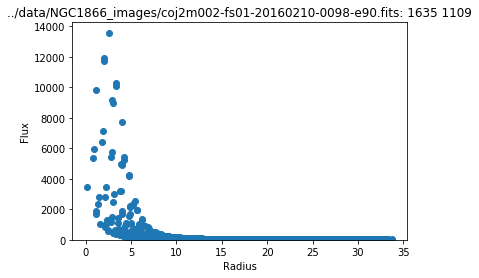

xc=1547.195264	yc=1202.668183


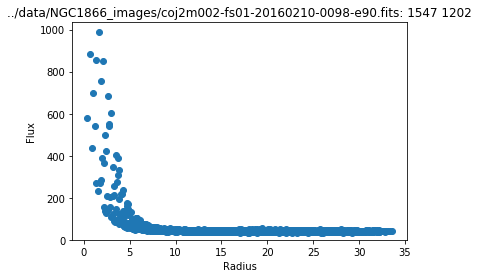

xc=1217.814439	yc=1388.960584


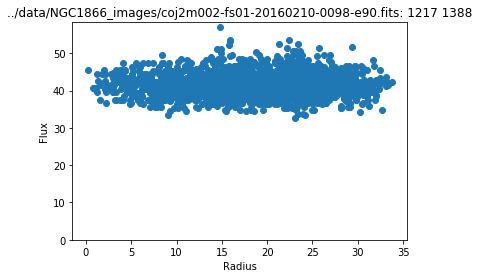

contour centered at: 1635.76 1110.8


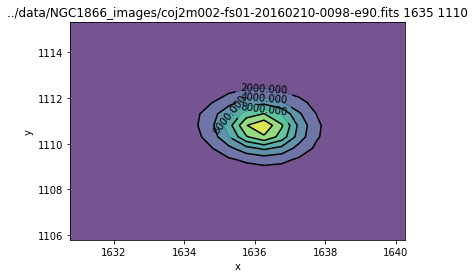

contour centered at: 1546.48 1202.96


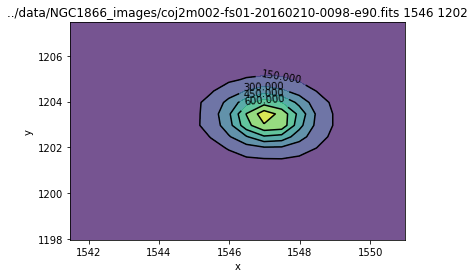

contour centered at: 1213.84 1511.12


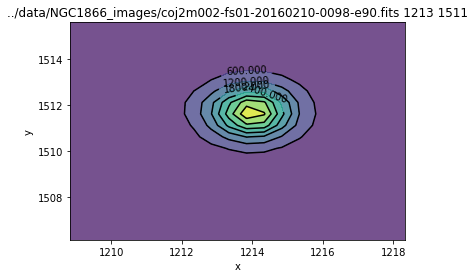

xc=1635.826166	yc=1109.876887
x              y              radius         flux           mag(zpt=25.00)sky             fwhm
1635.83        1109.88        12             282886.49      11.37                         46.15          4.24
xc=1547.195236	yc=1202.668184
x              y              radius         flux           mag(zpt=25.00)sky             fwhm
1547.20        1202.67        12             20343.63       14.23                         41.35          4.82
xc=1217.814439	yc=1388.960584
x              y              radius         flux           mag(zpt=25.00)sky             fwhm
1217.81        1388.96        12             -135.92        nan                           41.66          14847.28
[1103:1115,1629:1641] median: 679.0108642578125
[1196:1208,1540:1552] median: 87.40943908691406
[1506:1518,1207:1219] median: 253.88217163085938


In [93]:
ds9viewer.imexam()

#### Deciding on list of images to use in the template image
Using the radial profile and countour plots, and the aperture sum and square region stats I picked the following 7 images to use in the template:

In [7]:
template_files = [filesByWaveband['I'][i] for i in [3,14,15,16,18,26,30]]

## Step 2: Finding objects in the template images

We'll use DAOStarFinder to create catalogs for each image

### Making a class to hold all the information we need for each image

In [8]:
class ImageInfo:
    """
    Class to hold all the information for aligning a fits image file.
    
    The fits file is assumed to have one extension with WCS info in the header and an image array for data.
    """
    
    filename = None
    
    initial_image = None
    initial_header = None
    initial_wcs = WCS()
    
    corrected_image = None
    corrected_wcs = WCS()
    
    catalog = Table()
    fixed_stars = Table()
    
    mean = None
    median = None
    std = None
    fwhm = None
    
    
    def __init__(self,filename):
        self.filename = filename
        self.initial_image = fits.getdata(filename,0)
        self.initial_header = fits.getheader(filename,0)
        self.initial_wcs = WCS(filename)
    

#### Initializing the class for each file

In [9]:
template_images = [ImageInfo(fle) for fle in template_files]

While examining all the images with imexam, one of the things I kept track of was the fwhm for each image, so I will now add that information to the classes manually.

In [10]:
template_fwhm = [4.9,6.4,5.2,7.3,7.4,5.5,4.8] # obtained with imexamin
for i,img in enumerate(template_images):
    img.fwhm = template_fwhm[i]

And adding one more round of things:

In [11]:
for img in template_images:
    img.mean, img.median, img.std = sigma_clipped_stats(img.initial_image, sigma=3.0, iters=5)

### Getting the 'canonical' sky positions of the target stars using Gaia

We want a few stars that we know their correct position, to fine in the images, I am going to go ahead and enter the info now, because we will want to create the catalogs and find these stars in the images at the same time.

I could maybe have done something clever with catalog crossmatch here, but what I actually did is open up ESASky (http://sky.esa.int/), search for NGC 1866, load the Gaia sources on top and find the ones that corresponed to the stars I picked out.  Then I added these coordinates in manually.

Note: I am using the same stars I used in the V-band, so I already had the Gaia coordinates for them.

In [100]:
for img in template_images:
    img.fixed_stars = Table()
    img.fixed_stars['ra'] = [78.28064,78.29842,78.36535,78.24656,78.25705,78.56488,78.27106]
    img.fixed_stars['dec'] = [-65.45482,-65.44702,-65.421,-65.41576,-65.4071,-65.4497,-65.54136]
    img.fixed_stars['coord'] = SkyCoord(img.fixed_stars['ra'], img.fixed_stars['dec'], unit=u.deg) # for wcs fitting

### Making a catalog for each image and find the fixed stars

We will combine these steps because the threshold we use to create the template affects our ability to find the stars.

In [12]:
def plot_fixed_stars(img, fixed_stars):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    positions = (fixed_stars['x'], fixed_stars['y'])
    apertures = CircularAperture(positions, r=15.)
    norm = LogNorm(vmin=0.01,vmax=3000)
    ax.imshow(img, cmap='Greys', norm=norm, origin='lower')
    apertures.plot(color='red', lw=1.5, alpha=0.25)

In [123]:
def find_sources(img, threshold):
    daofind = DAOStarFinder(fwhm=img.fwhm, threshold=threshold*img.std)
    img.catalog = daofind(img.initial_image - img.median)
    
    # Adding initial ra and dec guesses based on file WCS
    img.catalog['ra'],img.catalog['dec'] = img.initial_wcs.wcs_pix2world(img.catalog['xcentroid'],
                                                                         img.catalog['ycentroid'],0)
    img.catalog['coord'] = SkyCoord(img.catalog['ra'], img.catalog['dec'], unit=u.deg)
    
    # Getting the x,y coordinates of the fixed stars
    xs = []
    ys = []
    for star in img.fixed_stars:
        idx,_,_= star['coord'].match_to_catalog_sky(img.catalog['coord'])
        xs.append(img.catalog['xcentroid'][idx])
        ys.append(img.catalog['ycentroid'][idx])

    img.fixed_stars['x'] = xs
    img.fixed_stars['y'] = ys
    
    # sanity check plot
    plot_fixed_stars(img.initial_image, img.fixed_stars)
    plt.show()

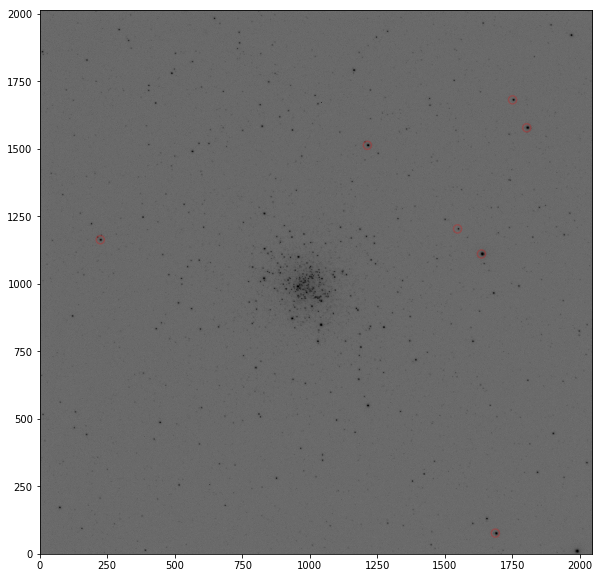

In [135]:
find_sources(template_images[6],100)

## Step 3: Correcting image WCS info

We will use the Gaia catalog to get accurate sky coordinates for a number of stars in the images. We will use those stars and their corresponding x,y pixel coordinates in each individual image to create a corrected WCS object.

We will want to use the Gaia catalog over the same region as our images, so I will go ahead and grab that as well. (I used the MAST catalog interface in Astroquery insteat of the Gaia one just because I am more familier with it.)

Figuring out the radius to search (rough is fine):

In [13]:
center_ra,center_dec = template_images[0].initial_wcs.wcs.crval
corner_ra,corner_dec =  template_images[0].initial_wcs.wcs_pix2world(0,0,0)
approx_radius = ((corner_ra - center_ra)**2 + (corner_dec - center_dec)**2)**0.5
print(approx_radius)

0.223246917626


In [14]:
coord = SkyCoord(ra=center_ra, dec=center_dec, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(0.23, u.deg)

Performing the catalog search

In [15]:
# There is a @#^&@#%^& newly introduced bug in the Gaia request that I will be fixing this week (sigh)
#gaiaCatalog = Catalogs.query_region(coord,radius,"Gaia")
service = "Mast.Catalogs.GaiaDR2.Cone"
params = {'ra':center_ra,
          'dec':center_dec,
          'radius':0.23}

gaiaCatalog = Catalogs.service_request(service,params)

We are going to want a sky coordinate column later on, so we will go ahead and add it now.

In [16]:
gaiaCatalog['coord'] = SkyCoord(gaiaCatalog['ra'],gaiaCatalog['dec'],unit=u.deg)

In [17]:
print("Number of Gaia sources: {}".format(len(gaiaCatalog)))
gaiaCatalog[:5]

Number of Gaia sources: 39736


solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,distance,coord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
str19,str28,str19,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,int64,int64,float64,int64,int64,bool,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,object
1635721458409799680,Gaia DR2 4663636057376659712,4663636057376659712,427898789,2015.5,78.4120422421,4.27604382695,-65.4652240956,12.7047652183,--,--,--,--,--,--,--,0.9805098,--,--,--,--,--,--,--,--,--,62,0,62,0,36.375145,1988.17346,4.17467426453,163.441602055,3,False,0.0540431365,--,--,0.118001595,7,6,22.2409153,0,72,True,601,2276.387708,11.8573915251,191.980484,17.29525,0,--,--,--,--,0,--,--,--,--,--,2,--,--,--,--,--,0,--,--,--,NOT_AVAILABLE,275.596089639,-34.5941469336,7.75119049795,-85.1711129062,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.0135046131579,"78.4120422421089,-65.46522409557878"
1635721458409799680,Gaia DR2 4663636057376670208,4663636057376670208,168164270,2015.5,78.4112600292,0.257338950507,-65.4651635879,0.280606229611,-1.30126506212,0.268479657171,-4.846792,2.21457269047,0.476748545523,2.92686531,0.552304527986,-0.08454744,-0.121518195,0.380233943,0.0175787881,0.389032573,-0.09119922,-0.3754463,-0.00255791633,-0.319778472,0.08734717,161,0,159,2,65.26112,6476.91064,2.10095278077,303.104788258,31,False,0.217333809,1.77993677642,0.0672534430204,-0.004358385,18,14,0.512235463,0,81,False,700,10548.9340246,59.5533667044,177.13414,15.6303444,6,22120.0082389,690.166027015,32.05027,14.4894247,5,13292.0005322,27.7634235908,478.75943,14.4529438,3.35692763,1,0.0364809036,-1.14091969,1.17740059,--,--,0,--,--,--,NOT_AVAILABLE,275.596087148,-34.5944773258,7.75065835875,-85.1707855587,112012,5095.6333,4259.0,6938.0,--,--,--,--,--,--,--,--,--,--,--,--,--,0.0208969201864,"78.41126002918035,-65.46516358788776"
163572

Now that we have the fixed stars, and the Gaia catalog, we'll fic the wcs info:

In [18]:
def plotSepHist(d2d):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.tick_params(axis='both', which='major', labelsize=14)
 
    ax.hist(d2d.arcsec, bins=40, range=(0,20),edgecolor='black',  linewidth=2,histtype='stepfilled', color="#d5d5d5")

    ax.axvline(2) # putting in a line at the fwhm
    ax.set_xlabel('separation [arcsec]',fontsize=14)

In [140]:
def correct_wcs(img):
    
    # Getting the corrected wcs info
    img.corrected_wcs = pixworld2wcs.wcs_pixworld2wcs(img.fixed_stars['x','y','coord'])
    
    # Checking the histogram
    ras,decs = img.corrected_wcs.wcs_pix2world(img.catalog['xcentroid'],img.catalog['ycentroid'],0)
    imgcoords = SkyCoord(ras,decs,unit=u.deg)
    idx, d2d, d3d = gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['coord'].match_to_catalog_sky(imgcoords)
    plotSepHist(d2d)
    plt.show()

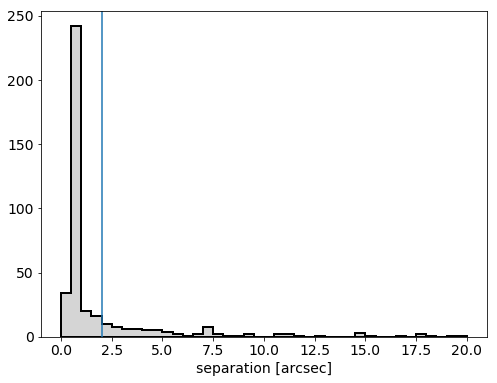

In [149]:
correct_wcs(template_images[6])

## Step 4: Reproject all the images onto a single projection

We'll project all of the imaged onto the same projection we used for the V-band using reproject (https://reproject.readthedocs.io).

In [68]:
def plotSourcesOverImage(source_x,source_y,img):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    positions = (source_x,source_y)
    apertures = CircularAperture(positions, r=10)
    norm = LogNorm(vmin=10,vmax=3000)
    ax.imshow(img, cmap='gray', norm=norm)
    apertures.plot(color='blue', lw=1.5, alpha=0.5, ax=ax)

In [20]:
v_temp_orig = fits.open(filesByWaveband['V'][3])
canonical_wcs = WCS(v_temp_orig[0])
canonical_shape = v_temp_orig[0].data.shape
v_temp_orig.close()

In [21]:
wcs_header = canonical_wcs.to_header()

In [166]:
def reproject_image(img):
    
    x,y = img.corrected_wcs.wcs_world2pix(gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['ra'],
                                          gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['dec'],0)
    plotSourcesOverImage(x,y,img.initial_image)
    plt.show()
    
    # Performing alignment (note, canonical wcs and shape already set above)
    img.corrected_image, footprint = reproject_interp((img.initial_image,img.corrected_wcs), 
                                                      canonical_wcs,canonical_shape)
    
    # Saving the aligned image to file
    header = img.initial_header
    for kwd in wcs_header:
        header[kwd] = wcs_header[kwd]
        
    hdu = fits.PrimaryHDU(img.corrected_image, header=header)
    hdu.writeto(img.filename.replace(".fits","_aligned.fits"),overwrite=True)
    

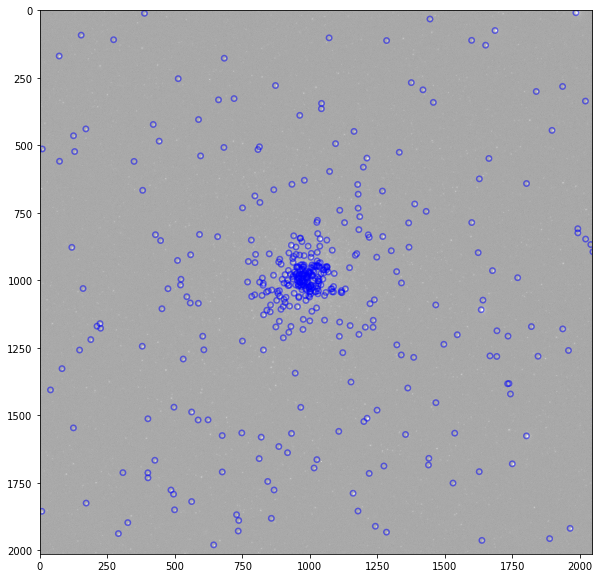

In [173]:
reproject_image(template_images[6])

## Step 5: Summing the images

Averaging with cosmic ray rejection.

In [179]:
ccdDataFrames =  [CCDData(x.corrected_image, unit=u.dimensionless_unscaled) for x in template_images]
combiner = Combiner(ccdDataFrames)

In [180]:
combiner.data_arr.mask[np.isnan(combiner.data_arr)]=True

In [185]:
old_n_masked = -1  # dummy value to make loop execute at least once
new_n_masked = combiner.data_arr.mask.sum()

print(new_n_masked)

while (new_n_masked > old_n_masked):
    combiner.sigma_clipping(func=np.ma.median,low_thresh=None,high_thresh=2)
    old_n_masked = new_n_masked
    new_n_masked = combiner.data_arr.mask.sum()
    
print(new_n_masked)

combined_average = combiner.average_combine()

892918


/Users/cbrasseur/anaconda/envs/astroconda/lib/python3.6/site-packages/ccdproc/combiner.py:307: RuntimeWarning: invalid value encountered in greater
  mask = (self.data_arr - baseline > high_thresh * dev)


906177


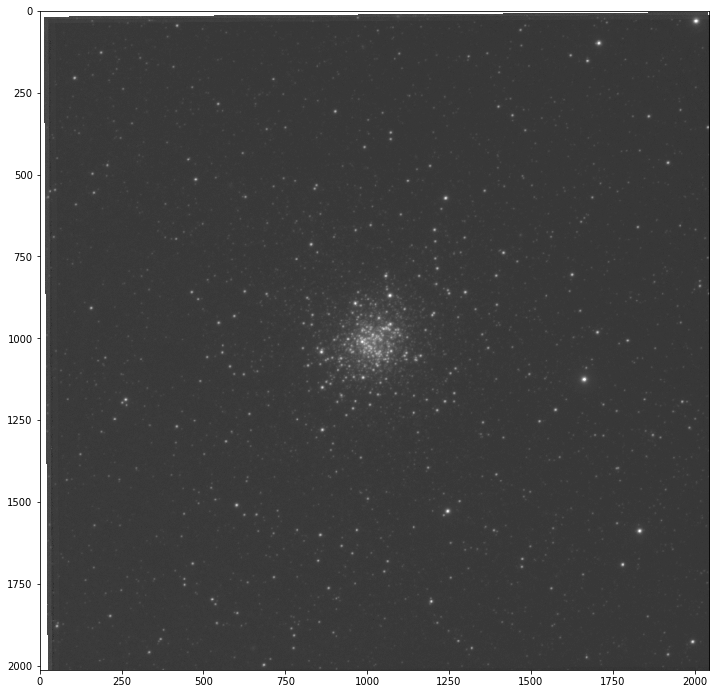

In [186]:
fig = plt.figure(figsize=(12,112))
ax1 = fig.add_subplot(111)

norm = LogNorm(vmin=10,vmax=3000)
ax1.imshow(combined_average, cmap='gray', norm=norm)

In [187]:
hdu = fits.PrimaryHDU(combined_average, header=canonical_wcs.to_header())
hdu.writeto("../data/i_mean_template_crr.fits", overwrite=True)

## Aligning the rest of the images to this template

I want to automate picking out the fixed stars in the image, because that's really labor intensive.
I'll start by looking for the stars in each image that are closest to the fixed stars and assuming those are a match.

In [62]:
fixed_stars = Table()

fixed_stars['ra'] = [78.28064,78.29842,78.36535,78.24656,78.25705,78.56488,78.27106]
fixed_stars['dec'] = [-65.45482,-65.44702,-65.421,-65.41576,-65.4071,-65.4497,-65.54136]
fixed_stars['coord'] = SkyCoord(fixed_stars['ra'], fixed_stars['dec'], unit=u.deg) # for wcs fitting

In [106]:
def align_file(fle, threshold=50):        
    print(fle)
    
    # read in the info we need
    hdu = fits.open(fle)
    img_data = hdu[0].data
    img_header = hdu[0].header
    img_wcs = WCS(hdu[0])
    hdu.close()
    
    mean, median, std = sigma_clipped_stats(img_data, sigma=3.0, iters=5)
    
    daofind = DAOStarFinder(fwhm=6.2, threshold=threshold*std) # Using a high threshold so we only get the brightest stars
    img_catalog = daofind(img_data - median)
    
    img_catalog['ra'],img_catalog['dec'] = img_wcs.wcs_pix2world(img_catalog['xcentroid'],img_catalog['ycentroid'],0)
    img_catalog['coord'] = SkyCoord(img_catalog['ra'], img_catalog['dec'], unit=u.deg)
    
    print("Number of sources in image:", len(img_catalog))
    
    # Getting the x,y coordinates of the fixed stars
    xs = []
    ys = []
    for star in fixed_stars:
        idx,_,_= star['coord'].match_to_catalog_sky(img_catalog['coord'])
        xs.append(img_catalog['xcentroid'][idx])
        ys.append(img_catalog['ycentroid'][idx])

    fixed_stars['x'] = xs
    fixed_stars['y'] = ys
    
    # sanity check plot
    plot_fixed_stars(img_data, fixed_stars)
    plt.show()
    
    # Getting the corrected wcs info
    corrected_wcs = pixworld2wcs.wcs_pixworld2wcs(fixed_stars['x','y','coord'])
    
    # Checking the histogram
    ras,decs = corrected_wcs.wcs_pix2world(img_catalog['xcentroid'],img_catalog['ycentroid'],0)
    imgcoords = SkyCoord(ras,decs,unit=u.deg)
    idx, d2d, d3d = gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['coord'].match_to_catalog_sky(imgcoords)
    plotSepHist(d2d)
    plt.show()
    
    # Plotting the brighter gaia sources over our image
    x,y = corrected_wcs.wcs_world2pix(gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['ra'],
                                      gaiaCatalog[gaiaCatalog['phot_g_mean_mag']<17]['dec'],0)
    plotSourcesOverImage(x,y,img_data)
    plt.show()
    
    # Performing alignment (note, canonical wcs and shape already set above)
    corrected_img, footprint = reproject_interp((img_data,corrected_wcs), canonical_wcs,canonical_shape)
    
    # Saving the aligned image to file
    for kwd in wcs_header:
        img_header[kwd] = wcs_header[kwd]
        
    hdu = fits.PrimaryHDU(corrected_img, header=img_header)
    hdu.writeto(fle.replace(".fits","_aligned.fits"),overwrite=True)

The indexes we used in the template: 3,14,15,16,18,26,30

../data/NGC1866_images/coj2m002-fs01-20151008-0154-e90.fits
Number of sources in image: 189


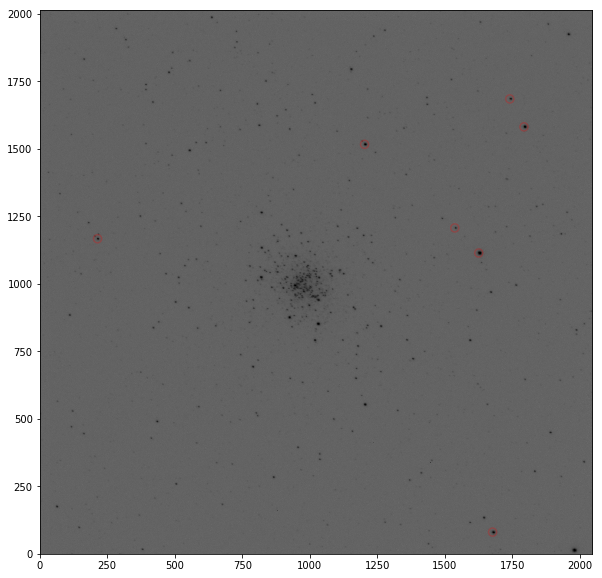

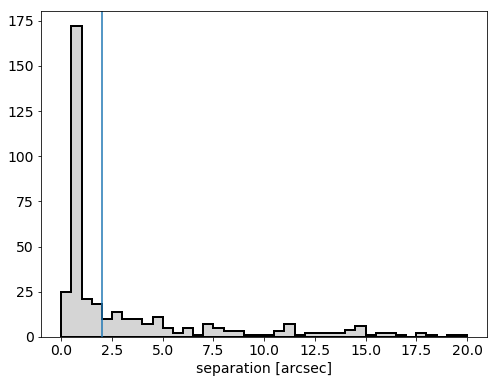

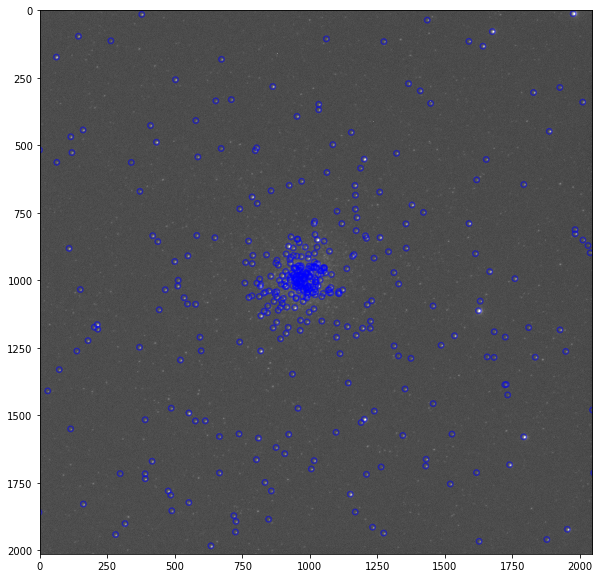

In [107]:
align_file(filesByWaveband['I'][2], threshold=100)

Not super sure about the fit for file 9 (just making a note in case there are issues with that file later)
Also, 32 and 33.